In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re

In [3]:
k = pd.read_csv("key_1.csv")
# sample = pd.read_csv("sample_submission_1.csv", nrows=100)
train = pd.read_csv("train_1.csv")

In [4]:
## median prediction method

In [5]:
# pd.read_csv("../input/key_1.csv",converters={'Page':lamabda p:p[:-11]}, index_col='Page').join(pd.read_csv("../input/train_1.csv", usecols=[0]+list(range(502,551)), index_col='Page').median(axis=1,skipna=True).to_frame(name='Visits'), how='left').fillna(0).to_csv('sub.csv', float_format='%.0f', index=False)

# k = pd.read_csv("key_1.csv", converters={"Page": lambda p: p[:-11]}, index_col = "Page")

# train = pd.read_csv("train_1.csv", usecols=[0] + list(range(502, 551)), index_col = "Page")

# k.join(train, how = 'left').fillna(0).to_csv("sub.csv", float_format = '%.0f', index = False)

In [6]:
## Use ARIMA

In [7]:
from statsmodels.tsa.arima_model import ARIMA

/Users/frank/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
# train_df = pd.read_csv('train_1.csv').fillna(0)
# train_df.head()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [10]:
train_df = train

In [11]:
def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res.group(0)[0:2]
    return 'na'

train_df['lang'] = train_df.Page.apply(find_language)

In [12]:
lang_sets = {}
lang_sets['en'] = train_df[train_df.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train_df[train_df.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train_df[train_df.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train_df[train_df.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train_df[train_df.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train_df[train_df.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train_df[train_df.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_df[train_df.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]
    

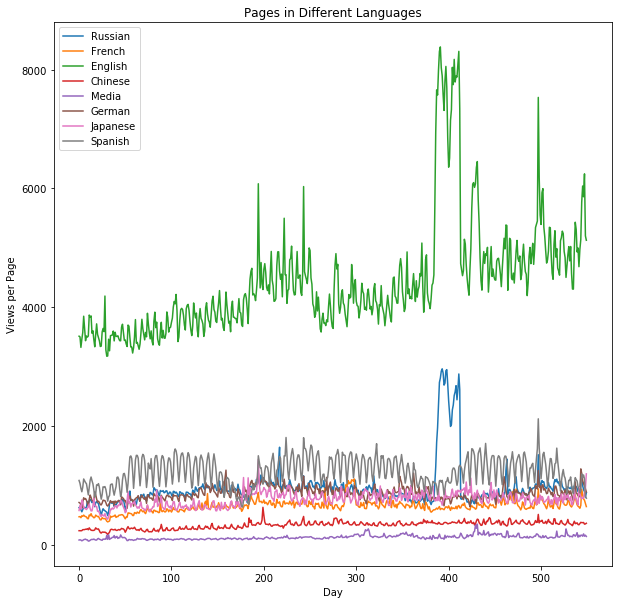

In [13]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

ru


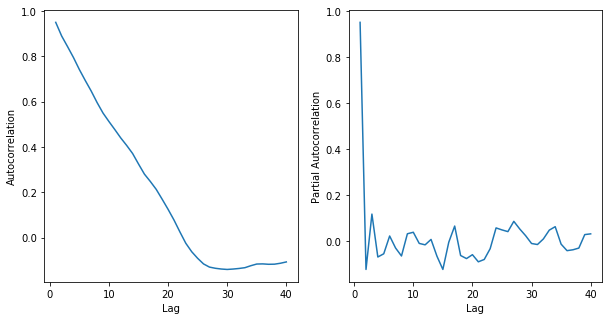

fr


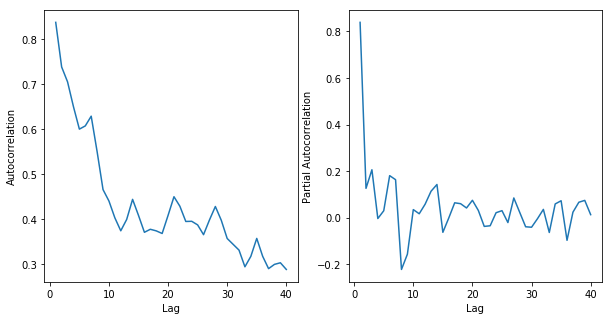

en


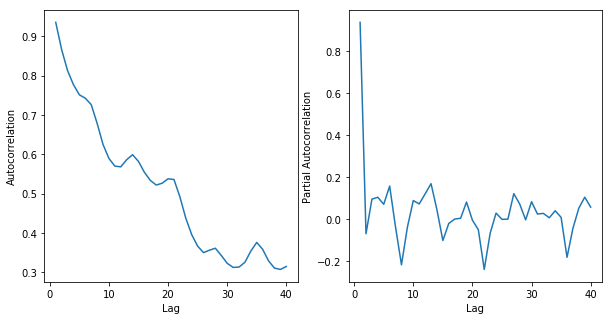

zh


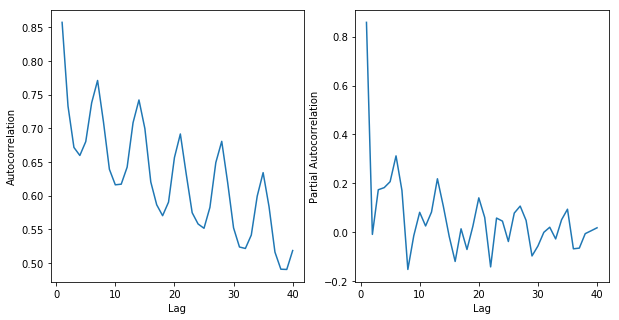

na


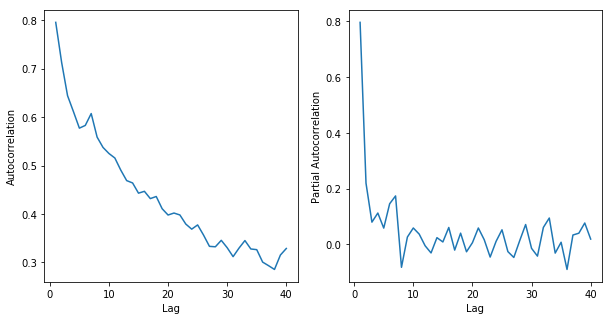

de


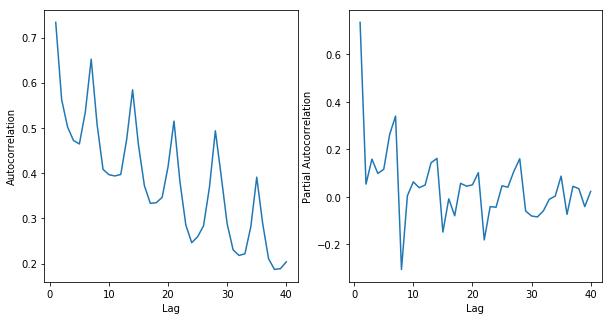

ja


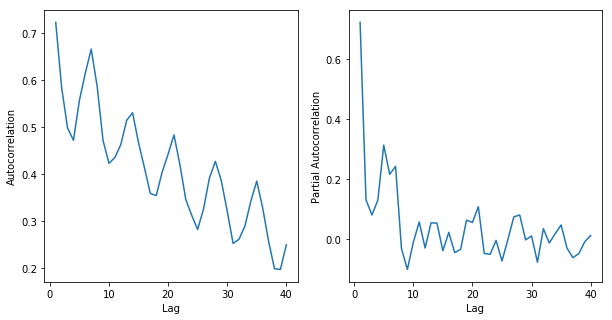

es


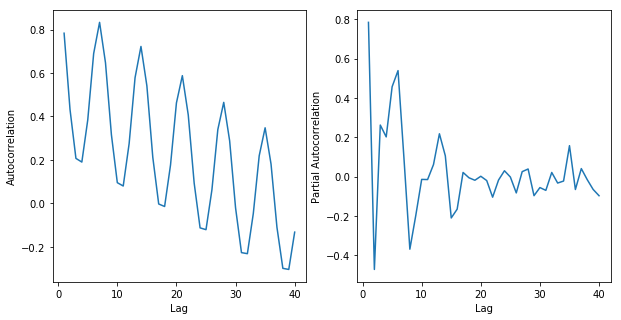

In [14]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in sums:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    data = np.array(sums[key])
    autocorr = acf(data)
    pac = pacf(data)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    print(key)
    plt.show()

In [15]:
sums.keys()

['ru', 'fr', 'en', 'zh', 'na', 'de', 'ja', 'es']

In [19]:
np.array(sums[key])

array([ 1085.97291918,  1037.81455683,   954.41268036,   896.05074988,
         974.50820954,  1110.6371455 ,  1082.56834174,  1050.66955718,
        1030.84128225,   937.12993105,   842.80865733,   960.24664155,
        1089.36555548,  1144.02580141,  1081.18366622,  1029.5220698 ,
         926.54531239,   806.1572251 ,   862.29739143,  1012.96758831,
        1003.3965456 ,  1032.55270453,   968.78818679,   860.50216789,
         771.0791101 ,   850.39100149,   979.42490582,   972.15153884,
         983.06141161,   935.02324259,   844.75179473,   737.78967944,
         809.86331651,   834.65548369,  1012.46662876,  1024.64823371,
        1025.45959201,   911.17200938,   838.28132774,   916.5881015 ,
         979.76224323,  1137.32212666,  1143.99793873,  1103.54758689,
         942.44601606,   816.30606298,   887.98613974,  1095.09147772,
        1196.61745682,  1205.01165683,  1141.85357879,  1042.52995949,
         887.03731609,  1034.57033194,  1277.17158291,  1482.51297178,
      

ru


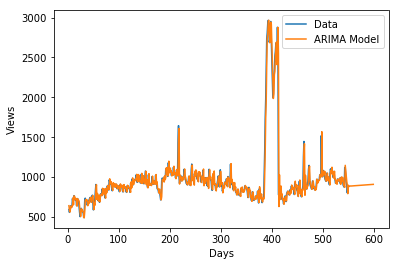

fr


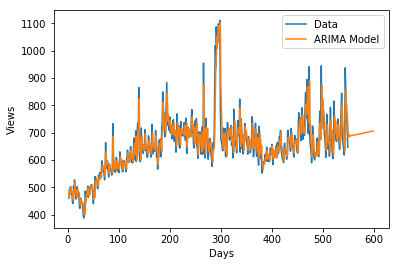

en


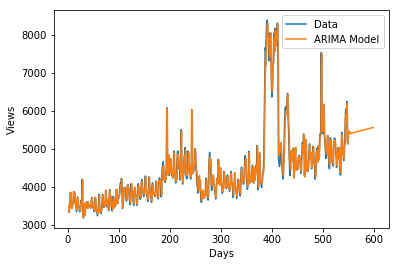

zh


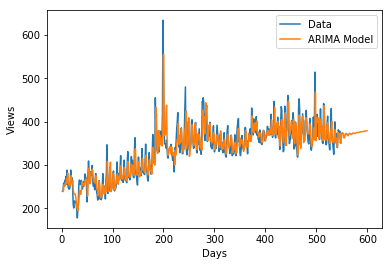

na


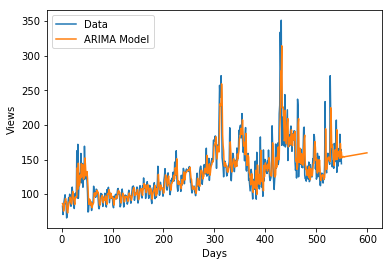

de


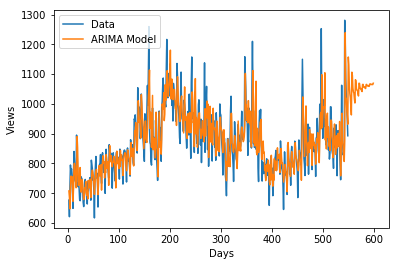

ja


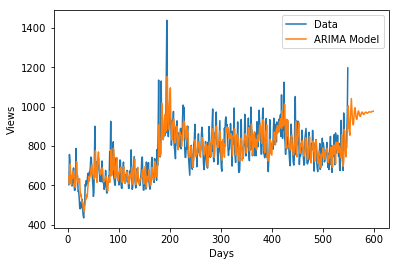

es


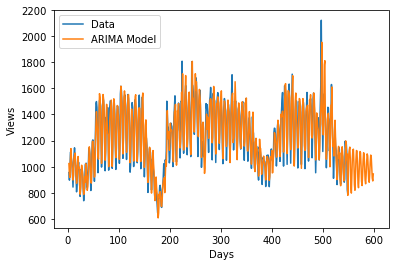

In [36]:
params = {'en': [4,1,0], 'ja': [7,1,1], 'de': [7,1,1], 'na': [4,1,0], 'fr': [4,1,0], 'zh': [7,1,1], 'ru': [4,1,0], 'es': [7,1,1]}

for key in sums:
    data = np.array(sums[key])
    result = None
    arima = ARIMA(data,params[key])
    result = arima.fit(disp=False)
    #print(result.params)
    pred = result.predict(2,599,typ='levels')
    x = [i for i in range(600)]
    i=0
    
    print(key)
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

In [35]:
ARIMA?

In [18]:
url = '2NE1_zh.wikipedia.org_all-access_spider'

In [18]:
url = '2NE1_zh.wikipedia.org_all-access_spider'

In [20]:
res = re.search('[a-z][a-z].wikipedia.org', url)

In [21]:
type(res)

_sre.SRE_Match

In [25]:
res.group(0)[:2]

'zh'